В данной работе разбирается и изучается соревнование на Kaggle.com
[Homesite Quote Conversion](https://www.kaggle.com/c/homesite-quote-conversion/overview)

Обзор данных и задач соревнования:
цель соревнования - создать модель предложения страхования жилья, которая приведет к покупке страхового полиса.

Используя анонимизированную базу данных информации о деятельности клиентов и продаж, включая информацию об имуществе и издержках, Homesite бросает вам вызов, чтобы предсказать, какие клиенты будут покупать страховку. 

Разбор задачи основан на решении победителя конкурса Far0n и членов его команды:
https://github.com/Far0n/kaggle-homesite  

In [56]:
from itertools import chain
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import xgboost as xgb
from PIL import Image
from IPython.display import display
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")


# ссылки на данные
train_file = "train.csv"
test_file = "test.csv"
sample_submission = "sample_submission.csv"
submission_filename = "god_of_overfitting_spare_us.csv"

# Загрузка данных

In [57]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
y_train = train.QuoteConversion_Flag

In [58]:
train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Columns: 299 entries, QuoteNumber to GeographicField64
dtypes: float64(6), int64(265), object(28)
memory usage: 594.8+ MB


In [60]:
# удаляю ненужные поля: порядковый номер и целевой признак из 
# тренировочного датасета
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)

# определяю длину тренировочного датасета (кол-во строк)
ntrain = train.shape[0]
# объединяю тренировочный и тестовый набор данных вместе
# для совместных преобразований данных
train_test = pd.concat((train, test), axis=0)

# преобразую строчные значения даты в вормат времени datetime
train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])
# добавляю новые числовые признаки связанные с датой
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day
train_test['Weekday'] = train_test['Date'].dt.dayofweek

# убираю запятую из строчного признака и конвертирую его в целое число
train_test['Field10'] = train_test['Field10'].apply(lambda x:
                                x.replace(',', '')).astype(np.int32)


In [61]:
# проверяю пропуски в данных
dataframe=train_test
lst=[]
for col in dataframe.columns:
	# count number of rows with missing values
	n_miss = dataframe[col].isnull().sum()
	perc = n_miss / dataframe.shape[0] * 100
	if n_miss>0:
		lst.append(col)        
	print('> %s, Missing: %d (%.1f%%)' % (col, n_miss, perc))

> Original_Quote_Date, Missing: 0 (0.0%)
> Field6, Missing: 0 (0.0%)
> Field7, Missing: 0 (0.0%)
> Field8, Missing: 0 (0.0%)
> Field9, Missing: 0 (0.0%)
> Field10, Missing: 0 (0.0%)
> Field11, Missing: 0 (0.0%)
> Field12, Missing: 0 (0.0%)
> CoverageField1A, Missing: 0 (0.0%)
> CoverageField1B, Missing: 0 (0.0%)
> CoverageField2A, Missing: 0 (0.0%)
> CoverageField2B, Missing: 0 (0.0%)
> CoverageField3A, Missing: 0 (0.0%)
> CoverageField3B, Missing: 0 (0.0%)
> CoverageField4A, Missing: 0 (0.0%)
> CoverageField4B, Missing: 0 (0.0%)
> CoverageField5A, Missing: 0 (0.0%)
> CoverageField5B, Missing: 0 (0.0%)
> CoverageField6A, Missing: 0 (0.0%)
> CoverageField6B, Missing: 0 (0.0%)
> CoverageField8, Missing: 0 (0.0%)
> CoverageField9, Missing: 0 (0.0%)
> CoverageField11A, Missing: 0 (0.0%)
> CoverageField11B, Missing: 0 (0.0%)
> SalesField1A, Missing: 0 (0.0%)
> SalesField1B, Missing: 0 (0.0%)
> SalesField2A, Missing: 0 (0.0%)
> SalesField2B, Missing: 0 (0.0%)
> SalesField3, Missing: 0 (0.0%)

> GeographicField64, Missing: 0 (0.0%)
> Date, Missing: 0 (0.0%)
> Year, Missing: 0 (0.0%)
> Month, Missing: 0 (0.0%)
> Day, Missing: 0 (0.0%)
> Weekday, Missing: 0 (0.0%)


In [62]:
print('Колонки с пропущенными значениями: ')
lst

Колонки с пропущенными значениями: 


['PersonalField7',
 'PersonalField84',
 'PropertyField3',
 'PropertyField4',
 'PropertyField5',
 'PropertyField29',
 'PropertyField30',
 'PropertyField32',
 'PropertyField34',
 'PropertyField36',
 'PropertyField38']

In [63]:
# смотрю, какие данные пропущены
print('Значения поля {}:, {}'.format('PersonalField7', train_test['PersonalField7'].unique()))
print('Значения поля {}:, {}'.format('PersonalField84', train_test['PersonalField84'].unique()))
print('Значения поля {}:, {}'.format('PropertyField3', train_test['PropertyField3'].unique()))
print('Значения поля {}:, {}'.format('PropertyField4', train_test['PropertyField4'].unique()))
print('Значения поля {}:, {}'.format('PropertyField5', train_test['PropertyField5'].unique()))
print('Значения поля {}:, {}'.format('PropertyField29', train_test['PropertyField29'].unique()))
print('Значения поля {}:, {}'.format('PropertyField30', train_test['PropertyField30'].unique()))
print('Значения поля {}:, {}'.format('PropertyField32', train_test['PropertyField32'].unique()))
print('Значения поля {}:, {}'.format('PropertyField34', train_test['PropertyField34'].unique()))
print('Значения поля {}:, {}'.format('PropertyField36', train_test['PropertyField36'].unique()))
print('Значения поля {}:, {}'.format('PropertyField38', train_test['PropertyField38'].unique()))

Значения поля PersonalField7:, ['N' 'Y' nan]
Значения поля PersonalField84:, [ 2. nan  1.  5.  4.  7.  8.  3.]
Значения поля PropertyField3:, ['N' 'Y' nan]
Значения поля PropertyField4:, ['N' 'Y' nan]
Значения поля PropertyField5:, ['Y' 'N' nan]
Значения поля PropertyField29:, [ 0. nan  1. 10.]
Значения поля PropertyField30:, ['N' 'Y' nan]
Значения поля PropertyField32:, ['Y' 'N' nan]
Значения поля PropertyField34:, ['Y' 'N' nan]
Значения поля PropertyField36:, ['N' 'Y' nan]
Значения поля PropertyField38:, ['N' 'Y' nan]


Видно что два поля имеют числовые значения, причем нехватка данных довольно значительная: 47-77%, остальные - строчные.
Можно было бы удалить данные, где нехватает большинство значений и заменить отсутствующие строчные каким нибудь статистическим значением, но автор пошел другим путем: он присвоил пропущенным значениям -1 с целью использовать этот трюк для создания новых признаков в дальнейшем, по всей видимости, для оценки веса входящих значений. 

In [64]:
# заменяю пропуск на -1
train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
train_test['GeographicField10AraphicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)

# удаляю временнЫе поля 
train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
# заменяю пропущенные значения -1
train_test = train_test.fillna(-1)

In [65]:
# определяю данные с категориального (строкового типа)
# и делаю Label encoder
categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']
for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))

Некоторые участники соревнования делали здесь One Hot encoder, но так как в дальнейшем будет использоваться модель XGboost, которая не чувствительна к стандартизации и скалированию, это не столь важно.

In [66]:
# разделяю выборки опять на тренировочную и тестовую
train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

На этом как бы подготовительный этап почти закончен, далее начинаем работать с признаками. 

Как отмечала команда Faronа в обсуждениях к соревнованиям они потратили многие недели на обработку данных, создали более 600 моделей:
  Xgbs, Nns(lasagne and keras), Rfs, Adaboosts, svms, ETs, Logits, Libfms , vowpal  
Использовали различные входные типы данных: только числовые, только категориальные, смешанные.
Использовали различный отбор признаков: прямой, обратный, смешанный.
И множество субмоделей с половиной признаков: модели за каждую неделю, каждый год и так далее.
После этого они применили метамодель (ансамбль) из 3-х уровней с различным отбором признаков и выбором моделей.

Ну на этом всем останавливаться не будем, потому что задачи такой нет. А есть задача рассмотреть лучшую одиночную модель конкурса Farona.

# Выделение важных признаков и конструирование новых

## Выделение важных признаков

Так как эта задача будет решаться с помощью XG бустинга начнем с выделения важнейших признаков.

Посмотрим на списки признаков, выделенных автором и попробую в них разобраться:

In [12]:
top111 = ['Field12', 'PersonalField52', 'PersonalField80', 'PersonalField44', 'Field9',
          'PropertyField7', 'PropertyField12', 'CoverageField5B', 'PersonalField42', 'PersonalField45',
          'PersonalField81', 'PropertyField8', 'PersonalField79', 'GeographicField45B', 'PropertyField22',
          'PersonalField75', 'PersonalField31', 'PropertyField19', 'PropertyField31', 'GeographicField11A',
          'PersonalField23', 'GeographicField21B', 'PersonalField4A', 'Field10', 'GeographicField16B',
          'GeographicField20A', 'PersonalField25', 'PersonalField4B', 'PropertyField3', 'GeographicField17A',
          'GeographicField59B', 'GeographicField7B', 'GeographicField8A', 'Year', 'GeographicField6B',
          'PersonalField14',
          'GeographicField45A', 'GeographicField14B', 'SalesField12', 'CoverageField11A', 'CoverageField5A', 'Month',
          'PropertyField33', 'PersonalField5', 'CoverageField11B', 'GeographicField11B', 'GeographicField23B',
          'PropertyField39B', 'CoverageField3A', 'GeographicField1B', 'GeographicField17B', 'PropertyField39A',
          'GeographicField41B', 'CoverageField6A', 'SalesField9', 'PersonalField16', 'PersonalField26',
          'PropertyField24A', 'Field8', 'GeographicField28A', 'CoverageField3B', 'SalesField2A', 'GeographicField19B',
          'GeographicField43A', 'PropertyField16B', 'PropertyField16A', 'PropertyField1B', 'CoverageField1B',
          'PropertyField1A', 'GeographicField48B', 'PersonalField11', 'CoverageField1A', 'PersonalField15',
          'GeographicField5B', 'PropertyField34', 'CoverageField8', 'PersonalField82', 'SalesField2B',
          'PropertyField35', 'CoverageField2B', 'SalesField10', 'PropertyField21A', 'SalesField3', 'CoverageField9',
          'SalesField7', 'Weekday', 'PersonalField13', 'PropertyField21B', 'SalesField6', 'SalesField1A',
          'PersonalField9', 'SalesField4', 'PersonalField12', 'PersonalField27', 'PersonalField10B', 'Field7',
          'SalesField1B', 'PersonalField84', 'PersonalField2', 'PersonalField1', 'SalesField5', 'PersonalField10A',
          'PropertyField37', 'PropertyField29', 'GeographicField4B', 'PropertyField2B', 'GeographicField1A',
          'GeographicField61B', 'Field11', 'PersonalField76', 'PropertyField30']

drop_out = ['GeographicField19B', 'PropertyField7', 'GeographicField17A', 'GeographicField28A',
            'GeographicField21B', 'GeographicField7B', 'CoverageField11B', 'GeographicField6B', 'GeographicField45A',
            'PersonalField25', 'Month', 'CoverageField5A', 'GeographicField8A', 'GeographicField1B',
            'CoverageField6A_CoverageField6B', 'PersonalField23', 'Field11', 'PropertyField2B', 'SalesField12',
            'GeographicField41B',
            'PropertyField16A', 'Field10', 'PropertyField3', 'PropertyField16B', 'GeographicField1A',
            'GeographicField20A', 'PersonalField81', 'GeographicField16B', 'GeographicField59B', 'PersonalField79',
            'CoverageField1A_CoverageField3A', 'CoverageField3B_CoverageField4B', 'PropertyField22',
            'GeographicField61B',
            'CoverageField3A_PropertyField21A', 'PropertyField12', 'CoverageField2A_CoverageField3A',
            'CoverageField2B_CoverageField3B', 'PropertyField8', 'PropertyField30', 'GeographicField14B',
            'PersonalField31',
            'PropertyField21A', 'CoverageField3A_CoverageField4A', 'PropertyField31', 'CoverageField11A',
            'PropertyField19', 'GeographicField45B', 'CoverageField1A', 'PersonalField75',
            'GeographicField8A_GeographicField13A', 'CoverageField3B_PropertyField21B',
            'CoverageField1B_CoverageField3B', 'GeographicField6A_GeographicField13A', 'CoverageField5B',
            'PersonalField42', 'PersonalField45', 'PersonalField76', 'GeographicField6A_GeographicField8A',
            'PersonalField80', 'Field9', 'CoverageField3A', 'CoverageField3B',
            'GeographicField8A_GeographicField11A', 'GeographicField11A_GeographicField13A',
            'GeographicField4B',
            'CoverageField2B', 'Field12', 'PropertyField21B', 'CoverageField1B', 'PersonalField44',
            'GeographicField6A_GeographicField11A', 'PersonalField52']

interactions2way = [
    ("CoverageField1B", "PropertyField21B"),
    ("GeographicField6A", "GeographicField8A"),
    ("GeographicField6A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField13A"),
    ("GeographicField11A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField11A"),
    ("GeographicField6A", "GeographicField11A"),
    ("CoverageField6A", "CoverageField6B"),
    ("CoverageField3A", "CoverageField4A"),
    ("CoverageField2B", "CoverageField3B"),
    ("CoverageField1A", "CoverageField3A"),
    ("CoverageField3B", "CoverageField4B"),
    ("CoverageField2A", "CoverageField3A"),
    ("CoverageField1B", "CoverageField3B"),
    ("CoverageField3B", "PropertyField21B"),
    ("CoverageField3A", "PropertyField21A"),
    ("CoverageField1B", "PropertyField16B"),
    ("Weekday", "SalesField7"),
    ("PersonalField9", "CoverageField6B"),
    ("PersonalField12", "CoverageField6A"),
    ("PropertyField16B", "PropertyField21A"),
    ("PersonalField12", "Field8"),
    ("PropertyField32", "PersonalField9"),
    ("Field6", "CoverageField6A"),
    ("PersonalField12", "CoverageField6A"),
    ("CoverageField6A", "PropertyField34"),
    ("PersonalField33", "PropertyField8"),
    ("CoverageField2A", "CoverageField3B")
]

interactions3way = [('PersonalField23', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField3A', 'PersonalField63', 'PropertyField21A'),
                    ('CoverageField3A', 'CoverageField4A', 'PersonalField76'),
                    ('CoverageField3A', 'CoverageField4A', 'GeographicField62A'),
                    ('CoverageField6A', 'PersonalField69', 'PersonalField9'),
                    ('CoverageField6A', 'PersonalField71', 'PersonalField9'),
                    ('GeographicField10B', 'GeographicField13A', 'PersonalField9'),
                    ('GeographicField8A', 'PersonalField71', 'PersonalField9'),
                    ('CoverageField2B', 'PersonalField75', 'PropertyField16B'),
                    ('CoverageField6A', 'PersonalField49', 'PropertyField29'),
                    ('CoverageField4B', 'PersonalField39', 'PropertyField16B'),
                    ('CoverageField11B', 'PersonalField6', 'SalesField2B'),
                    ('CoverageField11B', 'PersonalField36', 'SalesField2B'),
                    ('CoverageField2B', 'PropertyField16B', 'PropertyField8'),
                    ('CoverageField3A', 'GeographicField21A', 'PropertyField21B'),
                    ('GeographicField11A', 'PersonalField48', 'PersonalField9'),
                    ('CoverageField11B', 'PersonalField26', 'SalesField2B'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField61'),
                    ('CoverageField1A', 'PropertyField16A', 'PropertyField36'),
                    ('PersonalField9', 'PropertyField10', 'PropertyField32'),
                    ('GeographicField11A', 'GeographicField62A', 'PersonalField12'),
                    ('Field10', 'PersonalField9', 'PropertyField34'),
                    ('CoverageField2B', 'CoverageField3A', 'PersonalField8'),
                    ('Field11', 'PropertyField34', 'SalesField6'),
                    ('PersonalField19', 'PersonalField60', 'PropertyField8')]

interactions4way = [('Field8', 'PersonalField12', 'PersonalField75', 'PropertyField37'),
                    ('CoverageField6A', 'PersonalField12', 'PropertyField37', 'PropertyField8'),
                    ('Field8', 'PersonalField9', 'PropertyField3', 'PropertyField37'),
                    ('CoverageField6A', 'Field8', 'PersonalField84', 'PersonalField9'),
                    ('CoverageField8', 'PersonalField12', 'PersonalField80', 'PropertyField37'),
                    ('CoverageField8', 'Field8', 'PersonalField12', 'PersonalField84'),
                    ('CoverageField5A', 'GeographicField11A', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField1B', 'CoverageField3B', 'CoverageField5A', 'PropertyField22'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField82', 'PropertyField19'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField11', 'PropertyField19'),
                    ('CoverageField5A', 'Field8', 'PersonalField12', 'PersonalField42'),
                    ('CoverageField6A', 'Field11', 'PersonalField9', 'PropertyField12'),
                    ('CoverageField6A', 'CoverageField8', 'PropertyField35', 'SalesField3'),
                    ('CoverageField3A', 'PersonalField82', 'PropertyField21A', 'Year'),
                    ('CoverageField1B', 'CoverageField3B', 'PersonalField42', 'PropertyField8'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField1', 'PropertyField16A'),
                    ('CoverageField1B', 'CoverageField3B', 'PropertyField22', 'PropertyField8'),
                    ('CoverageField6A', 'PersonalField45', 'PersonalField9', 'PropertyField29'),
                    ('CoverageField5A', 'PersonalField1', 'PropertyField35', 'SalesField3'),
                    ('CoverageField1A', 'CoverageField3A', 'Field12', 'PersonalField27'),
                    ('CoverageField5A', 'CoverageField8', 'Field11', 'PropertyField29'),
                    ('CoverageField3B', 'PersonalField25', 'PersonalField45', 'PropertyField21B'),
                    ('CoverageField2B', 'CoverageField3B', 'GeographicField17A', 'PersonalField5'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField75', 'Year'),
                    ('Field11', 'PersonalField12', 'PersonalField25', 'PropertyField30')]


Списки interactions-k-way это списки взаимодействующих признаков (двух, трех и четырех признаков) влияющих на результат.

Для их получения автор воспользовался библиотекой xgbfir - портированной в питон библиотекой Xbfi написанной на C Far0n:
    
https://github.com/Far0n/xgbfi    

Библиотека служит для выделения важных и взаимодействующих признаков для xg бустинга

Посмотрим как она работает

In [13]:
!pip install xgbfir

In [15]:
import xgbfir

# обучаю классификатор
clf=xgb.XGBClassifier()
clf.fit(train, y_train)

# Сохраняю признаки в файл Excel
"""
'Gain' - gain-метрика для классификации, по которой 
        будем сортировать результат
TopK - количество выделенных верхних важных признаков
MaxInteractionDepth - верхняя граница выделенных взаимодействующих 
       признаков: 3 - это максимум 4 признака
Подробней здесь: https://github.com/limexp/xgbfir
"""
xgbfir.saveXgbFI(clf, MaxInteractionDepth=3, SortBy='Gain',
                 TopK=110,OutputXlsxFile='trainFI_Gain.xlsx')

В результате получаем Excel файл, где первые 4 листа - это списки признаков и 2 листа со статистиками.
Посмотрим как выглядит первый лист.

In [17]:
data_1=pd.read_excel('trainFI_Gain.xlsx', sheet_name=0)
data_1.head()

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,PropertyField37,86597.148303,32,17.813670,0.556677,2706.160884,33021.815931,1,34,4,3,1,2,7.500000,19.687500,2.812500
1,SalesField5,71397.838108,82,16.611652,0.202581,870.705343,69159.257148,2,2,5,29,2,1,6.833333,35.658537,3.243902
2,PersonalField9,41631.236343,81,32.161658,0.397058,513.965881,20984.613109,3,3,1,6,5,3,3.500000,19.814815,2.851852
3,PropertyField29,22710.464294,42,24.548049,0.584477,540.725340,14277.053129,4,14,2,1,4,4,4.833333,11.333333,1.714286
4,PersonalField2,14874.528123,27,5.839240,0.216268,550.908449,3454.437337,5,48,28,24,3,6,19.000000,32.000000,3.740741


In [19]:
# загружаю остальные листы и преобразую их в списки удобные в дальнейшем для преобразования признаков

data_2=pd.read_excel('trainFI_Gain.xlsx', sheet_name=1)
data_3=pd.read_excel('trainFI_Gain.xlsx', sheet_name=2)
data_4=pd.read_excel('trainFI_Gain.xlsx', sheet_name=3)
# список 110 самых важных одиночных признаков
lst_1way=list(data_1.Interaction)
# списки взимодействующих к-признаков, здесь я ограничусь первыми 60-ми
lst_2way=list(data_2.Interaction)[:60]
lst_3way=list(data_3.Interaction)[:60]
lst_4way=list(data_4.Interaction)[:60]

lst_2way=[tuple(x.split(sep='|')) for x in lst_2way]
lst_3way=[tuple(x.split(sep='|')) for x in lst_3way]
lst_4way=[tuple(x.split(sep='|')) for x in lst_4way]

In [21]:
# Посмотрим что получилось:

lst_1way

['PropertyField37',
 'SalesField5',
 'PersonalField9',
 'PropertyField29',
 'PersonalField2',
 'PersonalField1',
 'SalesField1B',
 'PersonalField12',
 'SalesField1A',
 'PersonalField27',
 'PersonalField10B',
 'PropertyField34',
 'SalesField4',
 'PersonalField13',
 'SalesField6',
 'CoverageField8',
 'Field7',
 'SalesField10',
 'PersonalField82',
 'PersonalField84',
 'PersonalField15',
 'SalesField3',
 'Field9',
 'PersonalField10A',
 'SalesField2B',
 'SalesField8',
 'GeographicField6A',
 'PersonalField11',
 'PropertyField35',
 'Weekday',
 'CoverageField11B',
 'CoverageField6A',
 'PropertyField39B',
 'PersonalField16',
 'PersonalField26',
 'PropertyField1B',
 'SalesField2A',
 'GeographicField5B',
 'PropertyField1A',
 'PropertyField39A',
 'PersonalField4A',
 'Field8',
 'SalesField9',
 'CoverageField11A',
 'CoverageField9',
 'PropertyField16A',
 'Day',
 'GeographicField61B',
 'PropertyField16B',
 'PersonalField18',
 'GeographicField1B',
 'PropertyField2B',
 'GeographicField8A',
 'Geographic

In [22]:
lst_4way

[('PersonalField9', 'PropertyField29', 'PropertyField37', 'SalesField5'),
 ('PersonalField1', 'PersonalField2', 'PropertyField29', 'PropertyField37'),
 ('PersonalField1', 'PersonalField9', 'PropertyField37', 'SalesField5'),
 ('PersonalField9', 'PersonalField9', 'PropertyField29', 'PropertyField37'),
 ('PersonalField10A', 'PersonalField9', 'PropertyField29', 'PropertyField37'),
 ('PersonalField1', 'PersonalField2', 'PersonalField9', 'PropertyField37'),
 ('PersonalField1', 'PersonalField9', 'PropertyField37', 'SalesField1B'),
 ('PersonalField1', 'PropertyField29', 'PropertyField37', 'SalesField1B'),
 ('PersonalField1', 'PersonalField12', 'PropertyField37', 'SalesField1B'),
 ('PersonalField9', 'PersonalField9', 'PropertyField37', 'SalesField5'),
 ('PersonalField9', 'PropertyField29', 'PropertyField37', 'SalesField1B'),
 ('PersonalField22', 'PersonalField9', 'PropertyField29', 'SalesField5'),
 ('Field7', 'PersonalField9', 'PropertyField29', 'PropertyField37'),
 ('GeographicField34A',
  'Pe

In [24]:
# Для сравнения выделю 110 важных признаков обычным способом из бустера
k = clf.get_booster().trees_to_dataframe()
group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain = ('Gain', 'mean'))
gain=group[['feature_importance_gain']].sort_values(by='feature_importance_gain',ascending=False)
lst_best_gain=list(gain.index)[:110]

## Конструирование новых признаков

Участники соревнования использовали разные подходы для конструирования признаков:
    1. Добавляли log(x), sqrt(x), 1/x (где х был в топе важных признаков)
    2. Добавляли x+y, x-y, x*y, x/y (где х и у были в топе важных признаков или сильно коррелировали между собой)
    3. Делали более сложные комбинации: x+((1/w)*(y-z))) .

Автор же уделил внимание только в основном вычитанию комбинации признаков в так назывемом k-way взаимодействии (interraction).

Вот что он пишет: основание этому в том, что древовидная модель не фиксирует такого рода взаимодействия

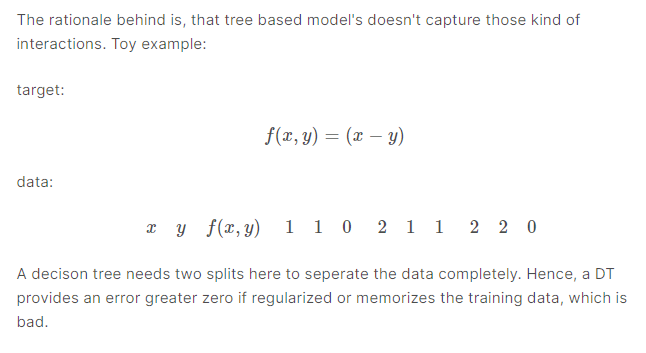

In [27]:
im=Image.open('pic1.PNG')
display(im)

In [28]:
# Создаем новые признаки путем их взиамного вычитания, используя списки автора
tc_features = []

for A, B in interactions2way:
    feat = "_".join([A, B]) 
    tc_features += [feat]
for A, B, C in interactions3way:
    feat = "_".join([A, B, C])
    tc_features += [feat]
    
for A, B, C, D in interactions4way:
    feat = "_".join([A, B, C, D])
    tc_features += [feat]

In [29]:
print('Количество новых признаков: ', len(tc_features))

Количество новых признаков:  78


## Визуализация полученных признаков

Попрбую визуализировать то что удалось выделить, чтобы определить пересечения наборов признаков

In [35]:
# все признаки автора без новых признаков
features = list(train.columns)
# помещаю список 111 автора в начале общего списка признаков, 
# а новые - в конце для лучшей наглядности
tmp_features=list(np.setdiff1d(features,top111))
f_all=top111+tmp_features+tc_features
# подготавливаю словарь признаков для визуализации
dict_features_sorted={}
for i in range(len(f_all)):
    dict_features_sorted[f_all[i]]=i
print('Количество признаков:', len(f_all))

Количество признаков: 379


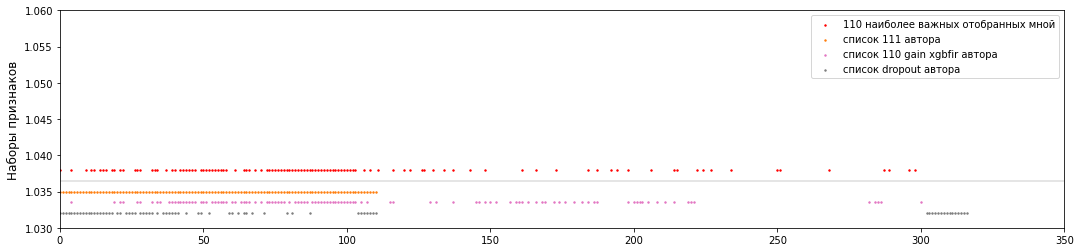

In [48]:
# визуализация признаков
fig=plt.figure(figsize=(18,4))

# список всех признаков
f1=list(dict_features_sorted.values())
y1=[1.037 for _ in range(len(f1))]

# список 111 автора
f_top111=[dict_features_sorted.get(z) for z in top111]
y_top111=[1.035 for _ in range(len(f_top111))]

# список gain от автора
f_gain=[dict_features_sorted.get(z) for z in lst_1way]
y_gain=[[1.0335 for _ in range(len(f_gain))]]

# список dropout
f_drop=[dict_features_sorted.get(z) for z in drop_out]
y_drop=[[1.032 for _ in range(len(f_drop))]]

# список 110 наиболее важных gain
f_best_sorted=[dict_features_sorted.get(z) for z in lst_best_gain]
y_best_sorted=[1.038 for _ in range(len(f_best_sorted))]

#plt.scatter(f1,y1, s=.7,c='C0', label='список всех полей ')
plt.scatter(f_best_sorted,y_best_sorted, s=2,c='red', label='110 наиболее важных отобранных мной')
plt.scatter(f_top111,y_top111, s=2,c='C1', label='список 111 автора')
plt.scatter(f_gain,y_gain, s=2,c='C6', label='список 110 gain xgbfir автора')
plt.scatter(f_drop,y_drop, s=2,c='C7', label='список dropout автора')
plt.hlines(1.0365, 0, 360, linewidth=.2)
plt.ylabel('Наборы признаков',size=12)
plt.ylim(1.03,1.06)
plt.xlim(0.,350.)
plt.legend()
plt.show()

Из графика видно, что набор drop_out автора состоит из признаков входящих в top111 и 15 признаков полученных в результате взаимодейстия.

Признаки top111 не совпадают с важными 110 признаками.

Отсюда, и исходя из публикаций на форуме, где автор пишет, что они искали лучшее сочетание признаков путем случайного перебора в течении нескольких дней, можно предположить, что top111 и drop_out - это две составляющие методики этого перебора и не предоставляется возможности восстановить эту технику.

Однако у меня есть аналогичное работающее решение с использованием оптимизации при отборе признаков которой я покажу позже.

А пока вернемся к решению автора.

# Решение автора

Итак, выделим списки признаков, найденные автором и параметры модели:

In [49]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}

top111 = ['Field12', 'PersonalField52', 'PersonalField80', 'PersonalField44', 'Field9',
          'PropertyField7', 'PropertyField12', 'CoverageField5B', 'PersonalField42', 'PersonalField45',
          'PersonalField81', 'PropertyField8', 'PersonalField79', 'GeographicField45B', 'PropertyField22',
          'PersonalField75', 'PersonalField31', 'PropertyField19', 'PropertyField31', 'GeographicField11A',
          'PersonalField23', 'GeographicField21B', 'PersonalField4A', 'Field10', 'GeographicField16B',
          'GeographicField20A', 'PersonalField25', 'PersonalField4B', 'PropertyField3', 'GeographicField17A',
          'GeographicField59B', 'GeographicField7B', 'GeographicField8A', 'Year', 'GeographicField6B',
          'PersonalField14',
          'GeographicField45A', 'GeographicField14B', 'SalesField12', 'CoverageField11A', 'CoverageField5A', 'Month',
          'PropertyField33', 'PersonalField5', 'CoverageField11B', 'GeographicField11B', 'GeographicField23B',
          'PropertyField39B', 'CoverageField3A', 'GeographicField1B', 'GeographicField17B', 'PropertyField39A',
          'GeographicField41B', 'CoverageField6A', 'SalesField9', 'PersonalField16', 'PersonalField26',
          'PropertyField24A', 'Field8', 'GeographicField28A', 'CoverageField3B', 'SalesField2A', 'GeographicField19B',
          'GeographicField43A', 'PropertyField16B', 'PropertyField16A', 'PropertyField1B', 'CoverageField1B',
          'PropertyField1A', 'GeographicField48B', 'PersonalField11', 'CoverageField1A', 'PersonalField15',
          'GeographicField5B', 'PropertyField34', 'CoverageField8', 'PersonalField82', 'SalesField2B',
          'PropertyField35', 'CoverageField2B', 'SalesField10', 'PropertyField21A', 'SalesField3', 'CoverageField9',
          'SalesField7', 'Weekday', 'PersonalField13', 'PropertyField21B', 'SalesField6', 'SalesField1A',
          'PersonalField9', 'SalesField4', 'PersonalField12', 'PersonalField27', 'PersonalField10B', 'Field7',
          'SalesField1B', 'PersonalField84', 'PersonalField2', 'PersonalField1', 'SalesField5', 'PersonalField10A',
          'PropertyField37', 'PropertyField29', 'GeographicField4B', 'PropertyField2B', 'GeographicField1A',
          'GeographicField61B', 'Field11', 'PersonalField76', 'PropertyField30']

drop_out = ['GeographicField19B', 'PropertyField7', 'GeographicField17A', 'GeographicField28A',
            'GeographicField21B', 'GeographicField7B', 'CoverageField11B', 'GeographicField6B', 'GeographicField45A',
            'PersonalField25', 'Month', 'CoverageField5A', 'GeographicField8A', 'GeographicField1B',
            'CoverageField6A_CoverageField6B', 'PersonalField23', 'Field11', 'PropertyField2B', 'SalesField12',
            'GeographicField41B',
            'PropertyField16A', 'Field10', 'PropertyField3', 'PropertyField16B', 'GeographicField1A',
            'GeographicField20A', 'PersonalField81', 'GeographicField16B', 'GeographicField59B', 'PersonalField79',
            'CoverageField1A_CoverageField3A', 'CoverageField3B_CoverageField4B', 'PropertyField22',
            'GeographicField61B',
            'CoverageField3A_PropertyField21A', 'PropertyField12', 'CoverageField2A_CoverageField3A',
            'CoverageField2B_CoverageField3B', 'PropertyField8', 'PropertyField30', 'GeographicField14B',
            'PersonalField31',
            'PropertyField21A', 'CoverageField3A_CoverageField4A', 'PropertyField31', 'CoverageField11A',
            'PropertyField19', 'GeographicField45B', 'CoverageField1A', 'PersonalField75',
            'GeographicField8A_GeographicField13A', 'CoverageField3B_PropertyField21B',
            'CoverageField1B_CoverageField3B', 'GeographicField6A_GeographicField13A', 'CoverageField5B',
            'PersonalField42', 'PersonalField45', 'PersonalField76', 'GeographicField6A_GeographicField8A',
            'PersonalField80', 'Field9', 'CoverageField3A', 'CoverageField3B',
            'GeographicField8A_GeographicField11A', 'GeographicField11A_GeographicField13A',
            'GeographicField4B',
            'CoverageField2B', 'Field12', 'PropertyField21B', 'CoverageField1B', 'PersonalField44',
            'GeographicField6A_GeographicField11A', 'PersonalField52']

interactions2way = [
    ("CoverageField1B", "PropertyField21B"),
    ("GeographicField6A", "GeographicField8A"),
    ("GeographicField6A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField13A"),
    ("GeographicField11A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField11A"),
    ("GeographicField6A", "GeographicField11A"),
    ("CoverageField6A", "CoverageField6B"),
    ("CoverageField3A", "CoverageField4A"),
    ("CoverageField2B", "CoverageField3B"),
    ("CoverageField1A", "CoverageField3A"),
    ("CoverageField3B", "CoverageField4B"),
    ("CoverageField2A", "CoverageField3A"),
    ("CoverageField1B", "CoverageField3B"),
    ("CoverageField3B", "PropertyField21B"),
    ("CoverageField3A", "PropertyField21A"),
    ("CoverageField1B", "PropertyField16B"),
    ("Weekday", "SalesField7"),
    ("PersonalField9", "CoverageField6B"),
    ("PersonalField12", "CoverageField6A"),
    ("PropertyField16B", "PropertyField21A"),
    ("PersonalField12", "Field8"),
    ("PropertyField32", "PersonalField9"),
    ("Field6", "CoverageField6A"),
    ("PersonalField12", "CoverageField6A"),
    ("CoverageField6A", "PropertyField34"),
    ("PersonalField33", "PropertyField8"),
    ("CoverageField2A", "CoverageField3B")
]

interactions3way = [('PersonalField23', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField3A', 'PersonalField63', 'PropertyField21A'),
                    ('CoverageField3A', 'CoverageField4A', 'PersonalField76'),
                    ('CoverageField3A', 'CoverageField4A', 'GeographicField62A'),
                    ('CoverageField6A', 'PersonalField69', 'PersonalField9'),
                    ('CoverageField6A', 'PersonalField71', 'PersonalField9'),
                    ('GeographicField10B', 'GeographicField13A', 'PersonalField9'),
                    ('GeographicField8A', 'PersonalField71', 'PersonalField9'),
                    ('CoverageField2B', 'PersonalField75', 'PropertyField16B'),
                    ('CoverageField6A', 'PersonalField49', 'PropertyField29'),
                    ('CoverageField4B', 'PersonalField39', 'PropertyField16B'),
                    ('CoverageField11B', 'PersonalField6', 'SalesField2B'),
                    ('CoverageField11B', 'PersonalField36', 'SalesField2B'),
                    ('CoverageField2B', 'PropertyField16B', 'PropertyField8'),
                    ('CoverageField3A', 'GeographicField21A', 'PropertyField21B'),
                    ('GeographicField11A', 'PersonalField48', 'PersonalField9'),
                    ('CoverageField11B', 'PersonalField26', 'SalesField2B'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField61'),
                    ('CoverageField1A', 'PropertyField16A', 'PropertyField36'),
                    ('PersonalField9', 'PropertyField10', 'PropertyField32'),
                    ('GeographicField11A', 'GeographicField62A', 'PersonalField12'),
                    ('Field10', 'PersonalField9', 'PropertyField34'),
                    ('CoverageField2B', 'CoverageField3A', 'PersonalField8'),
                    ('Field11', 'PropertyField34', 'SalesField6'),
                    ('PersonalField19', 'PersonalField60', 'PropertyField8')]

interactions4way = [('Field8', 'PersonalField12', 'PersonalField75', 'PropertyField37'),
                    ('CoverageField6A', 'PersonalField12', 'PropertyField37', 'PropertyField8'),
                    ('Field8', 'PersonalField9', 'PropertyField3', 'PropertyField37'),
                    ('CoverageField6A', 'Field8', 'PersonalField84', 'PersonalField9'),
                    ('CoverageField8', 'PersonalField12', 'PersonalField80', 'PropertyField37'),
                    ('CoverageField8', 'Field8', 'PersonalField12', 'PersonalField84'),
                    ('CoverageField5A', 'GeographicField11A', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField1B', 'CoverageField3B', 'CoverageField5A', 'PropertyField22'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField82', 'PropertyField19'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField11', 'PropertyField19'),
                    ('CoverageField5A', 'Field8', 'PersonalField12', 'PersonalField42'),
                    ('CoverageField6A', 'Field11', 'PersonalField9', 'PropertyField12'),
                    ('CoverageField6A', 'CoverageField8', 'PropertyField35', 'SalesField3'),
                    ('CoverageField3A', 'PersonalField82', 'PropertyField21A', 'Year'),
                    ('CoverageField1B', 'CoverageField3B', 'PersonalField42', 'PropertyField8'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField1', 'PropertyField16A'),
                    ('CoverageField1B', 'CoverageField3B', 'PropertyField22', 'PropertyField8'),
                    ('CoverageField6A', 'PersonalField45', 'PersonalField9', 'PropertyField29'),
                    ('CoverageField5A', 'PersonalField1', 'PropertyField35', 'SalesField3'),
                    ('CoverageField1A', 'CoverageField3A', 'Field12', 'PersonalField27'),
                    ('CoverageField5A', 'CoverageField8', 'Field11', 'PropertyField29'),
                    ('CoverageField3B', 'PersonalField25', 'PersonalField45', 'PropertyField21B'),
                    ('CoverageField2B', 'CoverageField3B', 'GeographicField17A', 'PersonalField5'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField75', 'Year'),
                    ('Field11', 'PersonalField12', 'PersonalField25', 'PropertyField30')]


In [50]:
# здесь автор удаляет повторяющиеся поля в разных списках и подготавливает их
# для генерации новых признаков - разности полей
interactions2way_list = list(np.unique(list(chain(*interactions2way))))
interactions3way_list = list(np.unique(list(chain(*interactions3way))))
interactions4way_list = list(np.unique(list(chain(*interactions4way))))

interactions_list = interactions2way_list + interactions3way_list + interactions4way_list
tmp_features = list(np.setdiff1d(interactions_list, top111))

tc_features = []


In [51]:
features = list(train.columns)
features = np.intersect1d(features, top111 + tmp_features)

x_train = train[features].copy()
x_test = test[features].copy()
# создание признака подсчета пропущенных значений
x_train['NaNCount'] = x_train.apply(lambda x: np.sum(x == -1), axis=1)
x_test['NaNCount'] = x_test.apply(lambda x: np.sum(x == -1), axis=1)

In [52]:
# создание взаимодействующих признаков и удаление не нужных
for A, B in interactions2way:
        feat = "_".join([A, B])
        x_train[feat] = x_train[A] - x_train[B]
        x_test[feat] = x_test[A] - x_test[B]

for A, B, C in interactions3way:
    feat = "_".join([A, B, C])
    tc_features += [feat]
    x_train[feat] = x_train[A] - x_train[B] - x_train[C]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C]

for A, B, C, D in interactions4way:
    feat = "_".join([A, B, C, D])
    tc_features += [feat]
    x_train[feat] = x_train[A] - x_train[B] - x_train[C] - x_train[D]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C] - x_test[D]

x_train.drop(tmp_features, axis=1, inplace=True)
x_test.drop(tmp_features, axis=1, inplace=True)

x_train.drop(drop_out[-25:], axis=1, inplace=True)
x_test.drop(drop_out[-25:], axis=1, inplace=True)

In [53]:

print (x_train.shape, x_test.shape)

(260753, 164) (173836, 164)


# Соединяю все вместе и обучаю модель

In [69]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auс'
}

top111 = ['Field12', 'PersonalField52', 'PersonalField80', 'PersonalField44', 'Field9',
          'PropertyField7', 'PropertyField12', 'CoverageField5B', 'PersonalField42', 'PersonalField45',
          'PersonalField81', 'PropertyField8', 'PersonalField79', 'GeographicField45B', 'PropertyField22',
          'PersonalField75', 'PersonalField31', 'PropertyField19', 'PropertyField31', 'GeographicField11A',
          'PersonalField23', 'GeographicField21B', 'PersonalField4A', 'Field10', 'GeographicField16B',
          'GeographicField20A', 'PersonalField25', 'PersonalField4B', 'PropertyField3', 'GeographicField17A',
          'GeographicField59B', 'GeographicField7B', 'GeographicField8A', 'Year', 'GeographicField6B',
          'PersonalField14',
          'GeographicField45A', 'GeographicField14B', 'SalesField12', 'CoverageField11A', 'CoverageField5A', 'Month',
          'PropertyField33', 'PersonalField5', 'CoverageField11B', 'GeographicField11B', 'GeographicField23B',
          'PropertyField39B', 'CoverageField3A', 'GeographicField1B', 'GeographicField17B', 'PropertyField39A',
          'GeographicField41B', 'CoverageField6A', 'SalesField9', 'PersonalField16', 'PersonalField26',
          'PropertyField24A', 'Field8', 'GeographicField28A', 'CoverageField3B', 'SalesField2A', 'GeographicField19B',
          'GeographicField43A', 'PropertyField16B', 'PropertyField16A', 'PropertyField1B', 'CoverageField1B',
          'PropertyField1A', 'GeographicField48B', 'PersonalField11', 'CoverageField1A', 'PersonalField15',
          'GeographicField5B', 'PropertyField34', 'CoverageField8', 'PersonalField82', 'SalesField2B',
          'PropertyField35', 'CoverageField2B', 'SalesField10', 'PropertyField21A', 'SalesField3', 'CoverageField9',
          'SalesField7', 'Weekday', 'PersonalField13', 'PropertyField21B', 'SalesField6', 'SalesField1A',
          'PersonalField9', 'SalesField4', 'PersonalField12', 'PersonalField27', 'PersonalField10B', 'Field7',
          'SalesField1B', 'PersonalField84', 'PersonalField2', 'PersonalField1', 'SalesField5', 'PersonalField10A',
          'PropertyField37', 'PropertyField29', 'GeographicField4B', 'PropertyField2B', 'GeographicField1A',
          'GeographicField61B', 'Field11', 'PersonalField76', 'PropertyField30']

drop_out = ['GeographicField19B', 'PropertyField7', 'GeographicField17A', 'GeographicField28A',
            'GeographicField21B', 'GeographicField7B', 'CoverageField11B', 'GeographicField6B', 'GeographicField45A',
            'PersonalField25', 'Month', 'CoverageField5A', 'GeographicField8A', 'GeographicField1B',
            'CoverageField6A_CoverageField6B', 'PersonalField23', 'Field11', 'PropertyField2B', 'SalesField12',
            'GeographicField41B',
            'PropertyField16A', 'Field10', 'PropertyField3', 'PropertyField16B', 'GeographicField1A',
            'GeographicField20A', 'PersonalField81', 'GeographicField16B', 'GeographicField59B', 'PersonalField79',
            'CoverageField1A_CoverageField3A', 'CoverageField3B_CoverageField4B', 'PropertyField22',
            'GeographicField61B',
            'CoverageField3A_PropertyField21A', 'PropertyField12', 'CoverageField2A_CoverageField3A',
            'CoverageField2B_CoverageField3B', 'PropertyField8', 'PropertyField30', 'GeographicField14B',
            'PersonalField31',
            'PropertyField21A', 'CoverageField3A_CoverageField4A', 'PropertyField31', 'CoverageField11A',
            'PropertyField19', 'GeographicField45B', 'CoverageField1A', 'PersonalField75',
            'GeographicField8A_GeographicField13A', 'CoverageField3B_PropertyField21B',
            'CoverageField1B_CoverageField3B', 'GeographicField6A_GeographicField13A', 'CoverageField5B',
            'PersonalField42', 'PersonalField45', 'PersonalField76', 'GeographicField6A_GeographicField8A',
            'PersonalField80', 'Field9', 'CoverageField3A', 'CoverageField3B',
            'GeographicField8A_GeographicField11A', 'GeographicField11A_GeographicField13A',
            'GeographicField4B',
            'CoverageField2B', 'Field12', 'PropertyField21B', 'CoverageField1B', 'PersonalField44',
            'GeographicField6A_GeographicField11A', 'PersonalField52']

interactions2way = [
    ("CoverageField1B", "PropertyField21B"),
    ("GeographicField6A", "GeographicField8A"),
    ("GeographicField6A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField13A"),
    ("GeographicField11A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField11A"),
    ("GeographicField6A", "GeographicField11A"),
    ("CoverageField6A", "CoverageField6B"),
    ("CoverageField3A", "CoverageField4A"),
    ("CoverageField2B", "CoverageField3B"),
    ("CoverageField1A", "CoverageField3A"),
    ("CoverageField3B", "CoverageField4B"),
    ("CoverageField2A", "CoverageField3A"),
    ("CoverageField1B", "CoverageField3B"),
    ("CoverageField3B", "PropertyField21B"),
    ("CoverageField3A", "PropertyField21A"),
    ("CoverageField1B", "PropertyField16B"),
    ("Weekday", "SalesField7"),
    ("PersonalField9", "CoverageField6B"),
    ("PersonalField12", "CoverageField6A"),
    ("PropertyField16B", "PropertyField21A"),
    ("PersonalField12", "Field8"),
    ("PropertyField32", "PersonalField9"),
    ("Field6", "CoverageField6A"),
    ("PersonalField12", "CoverageField6A"),
    ("CoverageField6A", "PropertyField34"),
    ("PersonalField33", "PropertyField8"),
    ("CoverageField2A", "CoverageField3B")
]

interactions3way = [
    ('PersonalField23', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField3A', 'PersonalField63', 'PropertyField21A'),
                    ('CoverageField3A', 'CoverageField4A', 'PersonalField76'),
                    ('CoverageField3A', 'CoverageField4A', 'GeographicField62A'),
                    ('CoverageField6A', 'PersonalField69', 'PersonalField9'),
                    ('CoverageField6A', 'PersonalField71', 'PersonalField9'),
                    ('GeographicField10B', 'GeographicField13A', 'PersonalField9'),
                    ('GeographicField8A', 'PersonalField71', 'PersonalField9'),
                    ('CoverageField2B', 'PersonalField75', 'PropertyField16B'),
                    ('CoverageField6A', 'PersonalField49', 'PropertyField29'),
                    ('CoverageField4B', 'PersonalField39', 'PropertyField16B'),
                    ('CoverageField11B', 'PersonalField6', 'SalesField2B'),
                    ('CoverageField11B', 'PersonalField36', 'SalesField2B'),
                    ('CoverageField2B', 'PropertyField16B', 'PropertyField8'),
                    ('CoverageField3A', 'GeographicField21A', 'PropertyField21B'),
                    ('GeographicField11A', 'PersonalField48', 'PersonalField9'),
                    ('CoverageField11B', 'PersonalField26', 'SalesField2B'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField61'),
                    ('CoverageField1A', 'PropertyField16A', 'PropertyField36'),
                    ('PersonalField9', 'PropertyField10', 'PropertyField32'),
                    ('GeographicField11A', 'GeographicField62A', 'PersonalField12'),
                    ('Field10', 'PersonalField9', 'PropertyField34'),
                    ('CoverageField2B', 'CoverageField3A', 'PersonalField8'),
                    ('Field11', 'PropertyField34', 'SalesField6'),
                    ('PersonalField19', 'PersonalField60', 'PropertyField8')]

interactions4way = [('Field8', 'PersonalField12', 'PersonalField75', 'PropertyField37'),
                    ('CoverageField6A', 'PersonalField12', 'PropertyField37', 'PropertyField8'),
                    ('Field8', 'PersonalField9', 'PropertyField3', 'PropertyField37'),
                    ('CoverageField6A', 'Field8', 'PersonalField84', 'PersonalField9'),
                    ('CoverageField8', 'PersonalField12', 'PersonalField80', 'PropertyField37'),
                    ('CoverageField8', 'Field8', 'PersonalField12', 'PersonalField84'),
                    ('CoverageField5A', 'GeographicField11A', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField1B', 'CoverageField3B', 'CoverageField5A', 'PropertyField22'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField82', 'PropertyField19'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField11', 'PropertyField19'),
                    ('CoverageField5A', 'Field8', 'PersonalField12', 'PersonalField42'),
                    ('CoverageField6A', 'Field11', 'PersonalField9', 'PropertyField12'),
                    ('CoverageField6A', 'CoverageField8', 'PropertyField35', 'SalesField3'),
                    ('CoverageField3A', 'PersonalField82', 'PropertyField21A', 'Year'),
                    ('CoverageField1B', 'CoverageField3B', 'PersonalField42', 'PropertyField8'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField1', 'PropertyField16A'),
                    ('CoverageField1B', 'CoverageField3B', 'PropertyField22', 'PropertyField8'),
                    ('CoverageField6A', 'PersonalField45', 'PersonalField9', 'PropertyField29'),
                    ('CoverageField5A', 'PersonalField1', 'PropertyField35', 'SalesField3'),
                    ('CoverageField1A', 'CoverageField3A', 'Field12', 'PersonalField27'),
                    ('CoverageField5A', 'CoverageField8', 'Field11', 'PropertyField29'),
                    ('CoverageField3B', 'PersonalField25', 'PersonalField45', 'PropertyField21B'),
                    ('CoverageField2B', 'CoverageField3B', 'GeographicField17A', 'PersonalField5'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField75', 'Year'),
                    ('Field11', 'PersonalField12', 'PersonalField25', 'PropertyField30')]


def get_data():
    global tc_features

    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)

    y_train = train.QuoteConversion_Flag

    train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
    test = test.drop('QuoteNumber', axis=1)

    ntrain = train.shape[0]

    train_test = pd.concat((train, test), axis=0)

    train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])

    train_test['Year'] = train_test['Date'].dt.year
    train_test['Month'] = train_test['Date'].dt.month
    train_test['Day'] = train_test['Date'].dt.day
    train_test['Weekday'] = train_test['Date'].dt.dayofweek

    train_test['Field10'] = train_test['Field10'].apply(lambda x: x.replace(',', '')).astype(np.int32)
    train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
    train_test['GeographicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)

    train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
    train_test = train_test.fillna(-1)

    categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']

    for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))

    train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
    test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

    features = list(train.columns)
    features = np.intersect1d(features, top111 + tmp_features)

    x_train = train[features].copy()
    x_test = test[features].copy()

    x_train['NaNCount'] = x_train.apply(lambda x: np.sum(x == -1), axis=1)
    x_test['NaNCount'] = x_test.apply(lambda x: np.sum(x == -1), axis=1)

    for A, B in interactions2way:
        feat = "_".join([A, B])
        x_train[feat] = x_train[A] - x_train[B]
        x_test[feat] = x_test[A] - x_test[B]

    for A, B, C in interactions3way:
        feat = "_".join([A, B, C])
        tc_features += [feat]
        x_train[feat] = x_train[A] - x_train[B] - x_train[C]
        x_test[feat] = x_test[A] - x_test[B] - x_test[C]

    for A, B, C, D in interactions4way:
        feat = "_".join([A, B, C, D])
        tc_features += [feat]
        x_train[feat] = x_train[A] - x_train[B] - x_train[C] - x_train[D]
        x_test[feat] = x_test[A] - x_test[B] - x_test[C] - x_test[D]

    x_train.drop(tmp_features, axis=1, inplace=True)
    x_test.drop(tmp_features, axis=1, inplace=True)

    x_train.drop(drop_out[-25:], axis=1, inplace=True)
    x_test.drop(drop_out[-25:], axis=1, inplace=True)

    return np.array(x_train), np.array(y_train), np.array(x_test)




In [70]:
x_train, y_train, x_test = get_data()
print (x_train.shape, x_test.shape)


(260753, 164) (173836, 164)


Важный момент: в ходе обученя модели автор использовал дообучение предварительно обученной модели с обнуленными в матрице k-way interracted признаками на матрице с уже включенными этими признаками

In [71]:
x_train_tc = x_train.copy()
ntcfeat = len(tc_features)

# обнуление k-way interracted признаков
x_train[:, -ntcfeat:] = 0

ntrain = x_train.shape[0]
best_nrounds = 2500

In [ ]:
# матрица с обнуленными признаками
dtrain = xgb.DMatrix(x_train, label=y_train)
# полная матрица
dtrain_tc = xgb.DMatrix(x_train_tc, label=y_train)

# первый этап обучения
gbdt = xgb.train(xgb_params, dtrain, best_nrounds - 100)
xgb_params['eta'] = 0.01
# второй этап обучения
gbdt = xgb.train(xgb_params, dtrain_tc, 300, xgb_model=gbdt)

dtest = xgb.DMatrix(x_test)
# получение результата
submission = pd.read_csv(sample_submission)
submission.iloc[:, 1] = gbdt.predict(dtest).reshape((-1, 1))
submission.to_csv(submission_filename, index=False)

# Проверяю результат

In [63]:
!kaggle competitions submit -c homesite-quote-conversion -f god_of_overfitting_spare_us.csv -m spare_us

Successfully submitted to Homesite Quote Conversion



  0%|          | 0.00/4.31M [00:00<?, ?B/s]
  8%|8         | 368k/4.31M [00:00<00:01, 3.53MB/s]
 38%|###7      | 1.63M/4.31M [00:00<00:00, 4.52MB/s]
 48%|####8     | 2.08M/4.31M [00:01<00:02, 828kB/s] 
 74%|#######4  | 3.21M/4.31M [00:01<00:01, 1.15MB/s]
 99%|#########8| 4.27M/4.31M [00:02<00:00, 1.57MB/s]
100%|##########| 4.31M/4.31M [00:03<00:00, 1.21MB/s]


In [64]:
!kaggle competitions submissions homesite-quote-conversion

fileName                         date                 description     status    publicScore  privateScore  
-------------------------------  -------------------  --------------  --------  -----------  ------------  
god_of_overfitting_spare_us.csv  2021-01-03 18:20:09  spare_us        complete  0.96928      0.96897       
god_of_overfitting_spare_us.csv  2021-01-02 15:24:21  spare_us        complete  0.96928      0.96897       
xgb_benchmark_5.csv              2021-01-02 09:51:38  xgb_benchmark   complete  0.96057      0.95992       
xgb_benchmark.csv                2021-01-02 08:25:12  xgb_benchmark   complete  0.96057      0.95992       
xgb_benchmark.csv                2021-01-02 08:21:42  xgb_benchmark   complete  0.96057      0.95992       
xgbr_benchmark.csv               2020-12-31 16:21:18  xgbr_benchmark  complete  0.73950      0.73853       
xgb_benchmark.csv                2020-12-31 05:54:28  xgb_benchmark   complete  0.96181      0.96115       
xgb_benchmark.csv           

Итак, полученный результат: 0.96928

# Решение с оптимизацией поиска признаков

In [73]:
from itertools import chain
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import xgboost as xgb
from PIL import Image
from IPython.display import display
from sklearn import preprocessing
import warnings
import pickle
from itertools import compress
import xgbfir
warnings.filterwarnings("ignore")


In [74]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
# определяю y
y_train = train.QuoteConversion_Flag
# удаляю ненужные поля: порядковый номер и целевой признак из 
# тренировочного датасета
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)
# определяю длину тренировочного датасета (кол-во строк)
ntrain = train.shape[0]
# объединяю тренировочный и тестовый набор данных вместе
# для совместных преобразований данных
train_test = pd.concat((train, test), axis=0)
# преобразую строчные значения даты в вормат времени datetime
train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])
# add new features as int numbers
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day
train_test['Weekday'] = train_test['Date'].dt.dayofweek
# replace drop comma from string feature and convert it to int
train_test['Field10'] = train_test['Field10'].apply(lambda x: x.replace(',', '')).astype(np.int32)
# заменяю пропуск на -1
train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
train_test['GeographicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)
# удаляю временные поля 
train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
# заменяю пропущенные значения -1
train_test = train_test.fillna(-1)
# определяю данные с категориального (строкового типа)
categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']
for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))
# разделяю выборки опять на тренировочную и тестовую
train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

Для создания новых признаков использую списки извлеченные с помощью библиотеки xgbfir ранее

In [75]:
# создаю новые признаки
for A, B in lst_2way:
    feat = "_".join([A, B])
    train[feat] = train[A] - train[B]
    
for A, B, C in lst_3way:
    feat = "_".join([A, B, C])
    train[feat] = train[A] - train[B] - train[C]
    
for A, B, C, D in lst_4way:
    feat = "_".join([A, B, C, D])
    train[feat] = train[A] - train[B] - train[C] - train[D]

## Случайный поиск важных и коррелирующих признаков с использованием оптимизации Hill climbing

In [78]:
# список всех признаков в датасете
col=list(train.columns)
len(col)

480

In [82]:
# задаю начальный субсет для поиска признаков: в данном случае это важных 110 признаков полученных ранее
subset_init=[True if x in lst_1way else False for x in col]

In [ ]:
# оптимизация для поиска признаков
"""
Важный показатель вероятности p_mut - если его задать как число деленное на длину списка признаков, 
то именно такое количество признаков будет меняться на каждом шаге.
Следовательно на начальном этапе можно использовать число побольше 15-30, позже остановить алгоритм 
и изменить его на меньшее - 2-5.

В случае остановки алгоритма последнее сохраненное на диске значение списка можно принять за начальный субсет
и запустить алгоритм по новому:

with open ('selected', 'rb') as fp:
    features = pickle.load(fp)
subset_init=[True if x in features else False for x in col]

"""
from numpy import mean
from numpy.random import rand
from numpy.random import choice
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score


# функция оценки набора признаков
def objective(X, y, subset):
	# конвертирование в индексы колонок
	ix = [i for i, x in enumerate(subset) if x]
	# проверка длины списка колонок
	if len(ix) == 0:
		return 0.0
	# выделение колонок
	X_new = X[:, ix]
	# определение модели
	model = xgb.XGBClassifier(n_estimators=3)
	# тренировка модели
	scores = cross_val_score(model, X_new, y, scoring='roc_auc', cv=3, n_jobs=-1)
	# оценка
	result = mean(scores)
	return result, ix

# оператор изменения списка колонок
def mutate(solution, p_mutate):
	# делаем копию
	child = solution.copy()
	for i in range(len(child)):
		# проверяем делать ли изменение 
		if rand() < p_mutate:
			# изменяем результат (инверсия)
			child[i] = not child[i]
	return child

# hill climbing алгоритм
def hillclimbing(X, y, objective, n_iter, p_mutate, solution_eval2, ix2, subset_init):
	# генерация начальной точки отсчета (важна при отсутствии инициирующего списка)
	solution = choice([True, False], size=X.shape[1])
	# оценка начального списка
	solution_eval, ix = objective(X, y, solution)
	# если результат хуже чем дает инициирующий список, принимаем инициирующий список за начальный   
	if solution_eval2>solution_eval:
		solution_eval, ix, solution=solution_eval2, ix2, subset_init        
	# запуск алгоритма
	for i in range(n_iter):
		# делаем шаг
		candidate = mutate(solution, p_mutate)
		# оцениваем сделанный шаг
		candidate_eval, ix = objective(X, y, candidate)
		# если результат лучше сохраненного заменяем лучший на него
		if candidate_eval >= solution_eval:
			# сохраняем новый результат
			solution, solution_eval = candidate, candidate_eval
		# рапорт о прогрессе
		print('>%d f(%s) = %f' % (i+1, len(ix), solution_eval))
		ixs = [i for i, x in enumerate(solution) if x]
		itemlist=list(train.columns[ixs])
		# здесь я сохраняю последний лучший результат на диск для его восстановления в случае остановки поиска        
		with open('selected', 'wb') as fp:
			pickle.dump(itemlist, fp)
	return solution, solution_eval

# определяю датасет
X, y = X_,Y_
# определяю количество итераций 
#( написал большое количество ибо мы защищены сохранением результата и в любой момент можем остановиться)
n_iter = 55000
# вероятность преобразования - шаг
p_mut = 5.0 / 480.0
# начинаю поиск

solution_eval2, ix2=objective(X, y, subset_init)
subset, score = hillclimbing(X, y, objective, n_iter, p_mut,solution_eval2, ix2, subset_init)
# преобразование в индексы колонок
ix = [i for i, x in enumerate(subset) if x]
print('Done!')
print('Best: f(%d) = %f' % (len(ix), score))
itemlist=list(train.columns[ix])
with open('final_selected', 'wb') as fp:
    pickle.dump(itemlist, fp)

## Решение

In [84]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
# определяю y
y_train = train.QuoteConversion_Flag
# удаляю ненужные поля: порядковый номер и целевой признак из 
# тренировочного датасета
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)
# определяю длину тренировочного датасета (кол-во строк)
ntrain = train.shape[0]
# объединяю тренировочный и тестовый набор данных вместе
# для совместных преобразований данных
train_test = pd.concat((train, test), axis=0)
# преобразую строчные значения даты в вормат времени datetime
train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])
# add new features as int numbers
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day
train_test['Weekday'] = train_test['Date'].dt.dayofweek
# replace drop comma from string feature and convert it to int
train_test['Field10'] = train_test['Field10'].apply(lambda x: x.replace(',', '')).astype(np.int32)
# заменяю пропуск на -1
train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
train_test['GeographicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)
# удаляю временные поля 
train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
# заменяю пропущенные значения -1
train_test = train_test.fillna(-1)
# определяю данные с категориального (строкового типа)
categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']
for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))
# разделяю выборки опять на тренировочную и тестовую
train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

In [85]:
x_train = train.copy()
x_test = test.copy()
# создание признака подсчета пропущенных значений
x_train['NaNCount'] = x_train.apply(lambda x: np.sum(x == -1), axis=1)
x_test['NaNCount'] = x_test.apply(lambda x: np.sum(x == -1), axis=1)

In [86]:
# создаю новые признаки
for A, B in lst_2way:
    feat = "_".join([A, B])
    x_train[feat] = x_train[A] - x_train[B]
    x_test[feat] = x_test[A] - x_test[B]
    
for A, B, C in lst_3way:
    feat = "_".join([A, B, C])
    x_train[feat] = x_train[A] - x_train[B] - x_train[C]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C]
    
for A, B, C, D in lst_4way:
    feat = "_".join([A, B, C, D])
    x_train[feat] = x_train[A] - x_train[B] - x_train[C] - x_train[D]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C] - x_test[D]

In [88]:
# загружаю сохраненный на диск список признаков
with open ('selected', 'rb') as fp:
    features = pickle.load(fp)
features=['NaNCount']+features

In [89]:
x_train=np.array(x_train[features])
y_train=np.array(y_train)
x_test=np.array(x_test[features])

In [90]:
# здесь я так определяю список признаков k-way interaction для обнуления
tc_features=[x for x in features if len(x)>35]
print (x_train.shape, x_test.shape)

(260753, 235) (173836, 235)


In [91]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}

In [92]:
x_train_tc = x_train.copy()
ntcfeat = len(tc_features)

# обнуление k-way interracted признаков
x_train[:, -ntcfeat:] = 0

ntrain = x_train.shape[0]
best_nrounds = 2500

In [ ]:
# матрица с обнуленными признаками
dtrain = xgb.DMatrix(x_train, label=y_train)
# полная матрица
dtrain_tc = xgb.DMatrix(x_train_tc, label=y_train)

# первый этап обучения
gbdt = xgb.train(xgb_params, dtrain, best_nrounds - 100)
xgb_params['eta'] = 0.01
# второй этап обучения
gbdt = xgb.train(xgb_params, dtrain_tc, 300, xgb_model=gbdt)

dtest = xgb.DMatrix(x_test)
# получение результата
submission = pd.read_csv(sample_submission)
submission.iloc[:, 1] = gbdt.predict(dtest).reshape((-1, 1))
submission.to_csv(submission_filename, index=False)